In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import platform
#from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np
import cv2
import scipy



# Monto Google Drive en el entorno de Google Colab
# drive.mount('/content/drive')
# Defino un punto de control para guardar el modelo
IsGoogleDrive=False
projectPath=os.getcwd()
if(IsGoogleDrive):
    checkpoint_path = '/content/drive/My Drive/model_checkpoint.h5'
    training_path= '/content/drive/MyDrive/Dataset_2/'
else:
    checkpoint_path  = os.path.join(projectPath,'model_checkpoint.h5')
    training_path= os.path.join(projectPath,'Dataset_2')
print(training_path)
#Cargo el modelo desde el último check

f:\Documentos\UBA\Nueva carpeta\Vision_por_computadora_2\Dataset_2


In [3]:
import scipy

# Paso 1: Cargo el modelo VGG16 preentrenado sin las capas densas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Paso 2: Congelo las capas convolucionales preentrenadas para evitar que se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Paso 3: Creo un modelo secuencial y agregar el modelo VGG16 preentrenado
model = Sequential()
model.add(base_model)

# Paso 4: Agrego capas densas personalizadas para la clasificación binaria
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria



checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

# Paso 5: Compilo el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 64

# Paso 6: Preparo el generador de datos de aumento y cargar datos
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    training_path,  # Directorio de datos de entrenamiento
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    training_path,  # Directorio de datos de validación
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)



Found 6851 images belonging to 2 classes.
Found 1711 images belonging to 2 classes.


In [4]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("Running on CPU")

Running on CPU


In [5]:
# Paso 7: Entreno el modelo con transfer learning
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint], initial_epoch=5)

Epoch 6/10


108/108 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.7622

C:\Users\Luli Santacruz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 371s 3s/step - loss: 0.4786 - accuracy: 0.7622 - val_loss: 0.3487 - val_accuracy: 0.8486
Epoch 7/10
 81/108 [=====================>........] - ETA: 1:17 - loss: 0.3271 - accuracy: 0.8561

KeyboardInterrupt: 

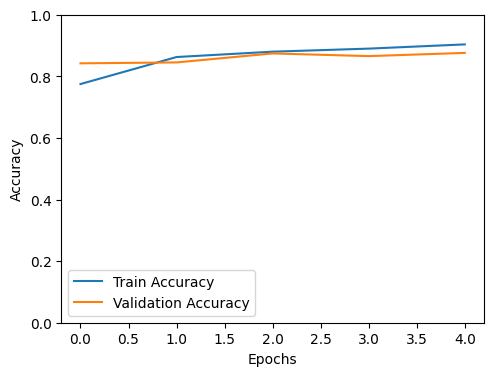

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Graficar las curvas de precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save(os.path.join(projectPath,'Saved_model_vgg'), save_format='tf')

INFO:tensorflow:Assets written to: f:\Documentos\UBA\Nueva carpeta\Vision_por_computadora_2\Saved_model_vgg\assets


INFO:tensorflow:Assets written to: f:\Documentos\UBA\Nueva carpeta\Vision_por_computadora_2\Saved_model_vgg\assets


In [ ]:
modelo = load_model(os.path.join(projectPath,'Saved_model_vgg'))
#modelo.summary()

In [ ]:
model.save(os.path.join(projectPath,'mi_modelo.keras'))

In [ ]:
modelo_cargado = load_model(os.path.join(projectPath,'mi_modelo.keras'))

In [ ]:
#Defino función de predicción
def prediccion(modelo,imagen,treshold):

    # Reshape para que coincida con el formato de entrada del modelo

     nueva_altura = 224
     nuevo_ancho = 224

     h, w = imagen.shape[:2]

    # Calcular el nuevo tamaño manteniendo la relación de aspecto original
     if h < w:
          nueva_altura_temp = int(nueva_altura * (h / w))
          nuevo_ancho_temp = nuevo_ancho
     else:
          nueva_altura_temp = nueva_altura
          nuevo_ancho_temp = int(nuevo_ancho * (w / h))

     imagen_redimensionada = cv2.resize(imagen,(nuevo_ancho_temp , nueva_altura_temp))

     imagen_redimensionada = imagen_redimensionada / 255.0

     # Crear una imagen en blanco del tamaño objetivo
     imagen_final = np.zeros((nueva_altura, nuevo_ancho, 3), dtype=np.uint8)

     # Calcular las coordenadas para copiar la imagen redimensionada en el centro
     y_offset = (nueva_altura - nueva_altura_temp) // 2
     x_offset = (nuevo_ancho - nuevo_ancho_temp) // 2

     # Copiar la región redimensionada en la ubicación calculada
     imagen_final[y_offset:y_offset + nueva_altura_temp, x_offset:x_offset + nuevo_ancho_temp] = imagen_redimensionada

     imagen_final = np.expand_dims(imagen_final, axis=0)


     # Realizar predicciones
     prediccion_imagen = modelo.predict(imagen_final)

     if prediccion_imagen > treshold:
          print(prediccion_imagen)
          return "La persona tiene sueño"
     else:
          print(prediccion_imagen)
          return "La persona no tiene sueño"



In [ ]:
#Cargo imágenes a testear

# Directorio en Google Drive que contiene las imágenes
directorio_drive = os.path.join(projectPath,'Imágenes de prueba','Con sueño')

# Obtener la lista de nombres de archivos en el directorio
nombres_archivos = os.listdir(directorio_drive)

# Filtrar solo los archivos de imagen (puedes ajustar según los tipos de archivos que tengas)
extensiones_imagen = ['.jpg', '.jpeg', '.png']
rutas_imagenes = [os.path.join(directorio_drive, archivo) for archivo in nombres_archivos if any(archivo.lower().endswith(ext) for ext in extensiones_imagen)]

imagenes = [cv2.imread(ruta) for ruta in rutas_imagenes]

#Realizo predicciones
for imagen, ruta in zip(imagenes, rutas_imagenes):
    # Realizar la predicción
    pred = prediccion(model, imagen, 0.45)
    # Mostrar la imagen con el resultado de la predicción
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicción: {pred}')
    plt.show()

NameError: name 'projectPath' is not defined